## Loading model

In [1]:
import numpy as np
%matplotlib inline
import os.path
import torch
import cv2
from ddim_inversion import sample, sample_rev
from show_tensor import show_tensor
from model_utils import *
from ddim_inversion import *
from load_ddim import load_ddim
device = torch.device("cuda")

In [2]:
argv = "scripts/sample_diffusion.py -r models/ldm/celeba256/model.ckpt -l ./logs -n 1 --batch_size 1".split()
opt, model = load_ddim(argv)

Logdir is models/ldm/celeba256
{'model': {'base_learning_rate': 2e-06, 'target': 'ldm.models.diffusion.ddpm.LatentDiffusion', 'params': {'linear_start': 0.0015, 'linear_end': 0.0195, 'num_timesteps_cond': 1, 'log_every_t': 200, 'timesteps': 1000, 'first_stage_key': 'image', 'cond_stage_key': 'class_label', 'image_size': 64, 'channels': 3, 'cond_stage_trainable': False, 'concat_mode': False, 'monitor': 'val/loss', 'unet_config': {'target': 'ldm.modules.diffusionmodules.openaimodel.UNetModel', 'params': {'image_size': 64, 'in_channels': 3, 'out_channels': 3, 'model_channels': 224, 'attention_resolutions': [8, 4, 2], 'num_res_blocks': 2, 'channel_mult': [1, 2, 3, 4], 'num_head_channels': 32}}, 'first_stage_config': {'target': 'ldm.models.autoencoder.VQModelInterface', 'params': {'embed_dim': 3, 'n_embed': 8192, 'ddconfig': {'double_z': False, 'z_channels': 3, 'resolution': 256, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 2, 4], 'num_res_blocks': 2, 'attn_resolutions': [], 'dr

In [3]:
diffusion = DDIMSampler(model, schedule="linear")
S = 50
eta = 0
verbose = False
diffusion.make_schedule(ddim_num_steps=S, ddim_eta=eta, verbose=verbose)

## Sampling random image

Running DDIM Sampling with 50 timesteps


DDIM: 100%|██████████| 50/50 [00:02<00:00, 20.74it/s]


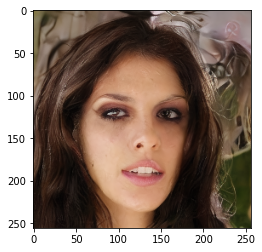

In [4]:
shape = [1, model.model.diffusion_model.in_channels,
         model.model.diffusion_model.image_size,
         model.model.diffusion_model.image_size]
x_T = torch.randn(shape).to(device)
samples_my, intermediates_my = sample(diffusion, x_T)
x_sample_my = model.decode_first_stage(samples_my)
show_tensor(x_sample_my[0])

## Calculate latents to Celeba-HQs image

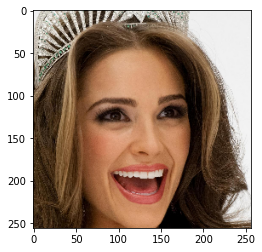

In [5]:
f_name = "./images/0.jpg"
celeba_img = cv2.imread(f_name, 1)
celeba_img_tensor = to_tensor(celeba_img).to(device)
show_tensor(celeba_img_tensor)

Running DDIM Reverse Sampling with 50 timesteps


DDIM Reverse: 100%|██████████| 50/50 [00:02<00:00, 20.04it/s]


Running DDIM Sampling with 50 timesteps


DDIM: 100%|██████████| 50/50 [00:02<00:00, 20.93it/s]


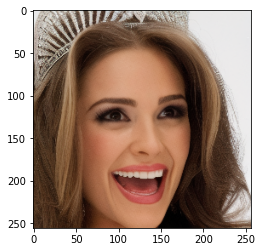

In [6]:
celeba_latents = img_to_latents(diffusion, celeba_img_tensor)
celeba_img_tensor_recon = latents_to_img(diffusion, celeba_latents)
show_tensor(celeba_img_tensor_recon[0])

## Interpolating between Celeba-HQ and random image

In [7]:
result = []
for alpha in [0, 0.25, 0.5, 0.75, 1]:
    print(f"Interpolating for alpha {alpha}...")
    latents_ = (alpha*celeba_latents + (1 - alpha)*x_T)/np.sqrt(alpha**2 + (1 - alpha)**2)
    img_ = latents_to_img(diffusion, latents_)
    result.insert(0, img_)
result = torch.cat(result, -1)

Interpolating for alpha 0...
Running DDIM Sampling with 50 timesteps


DDIM: 100%|██████████| 50/50 [00:02<00:00, 22.39it/s]


Interpolating for alpha 0.25...
Running DDIM Sampling with 50 timesteps


DDIM: 100%|██████████| 50/50 [00:02<00:00, 20.75it/s]


Interpolating for alpha 0.5...
Running DDIM Sampling with 50 timesteps


DDIM: 100%|██████████| 50/50 [00:02<00:00, 19.76it/s]


Interpolating for alpha 0.75...
Running DDIM Sampling with 50 timesteps


DDIM: 100%|██████████| 50/50 [00:02<00:00, 21.01it/s]


Interpolating for alpha 1...
Running DDIM Sampling with 50 timesteps


DDIM: 100%|██████████| 50/50 [00:02<00:00, 20.96it/s]


## Displaying results

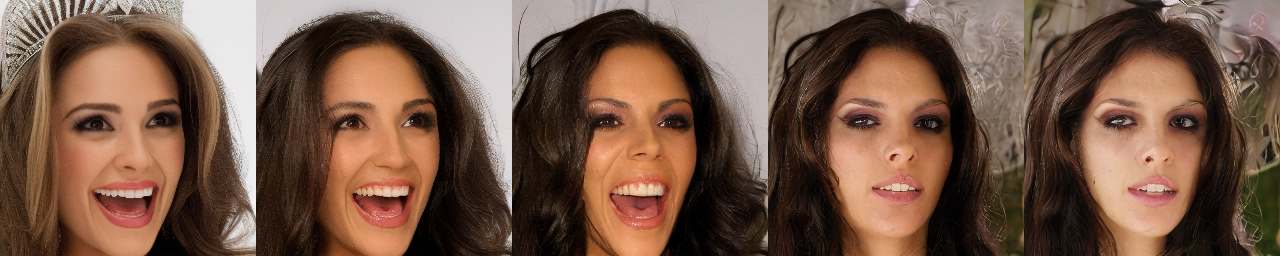

In [8]:
result_img = to_image(result[0])
cv2.imwrite("./out.png", result_img)

from IPython.display import display, Image
im = Image(filename="./out.png")
display(im)